In [31]:
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [34]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

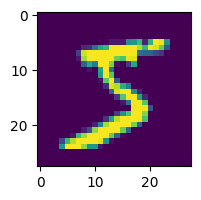

In [35]:
plt.figure(figsize = (15,2))
plt.imshow(X_train[0])

In [36]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [37]:
X_train = X_train.reshape((60000, 28, 28, 1))

In [38]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [39]:
X_test = X_test.reshape((10000, 28, 28, 1))

In [40]:
y_train[0]

5

In [41]:
np.max(X_train), np.max(X_test)

(255, 255)

In [42]:
X_train_sc = X_train/255
X_test_sc = X_test/255

In [43]:
np.max(X_train_sc), np.max(X_test_sc)

(1.0, 1.0)

In [48]:
from tensorflow import keras
from tensorflow.keras import layers, models 

cnn = keras.Sequential([
    layers.Conv2D(filters=28, kernel_size=(3,3), activation='relu', input_shape = (28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=60, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(60, activation='relu'),
    layers.Dense(10, activation='softmax')
    ])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn.fit(X_train_sc, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8999 - loss: 0.3255
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9855 - loss: 0.0481
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9894 - loss: 0.0335
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9925 - loss: 0.0237
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9940 - loss: 0.0176


In [50]:
cnn.evaluate(X_test_sc, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9882 - loss: 0.0360


[0.028558118268847466, 0.9901999831199646]

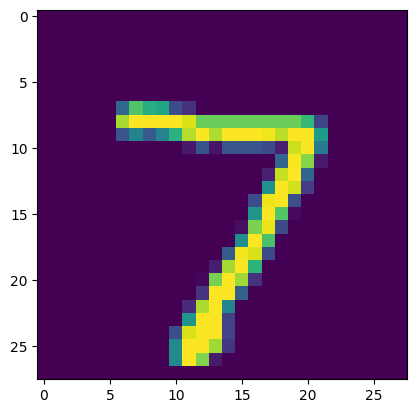

In [54]:
plt.imshow(X_test_sc[0])

In [55]:
y_test[0]

7

In [56]:
y_pred = cnn.predict(X_test_sc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [61]:
y_pred

array([[1.4114673e-10, 7.2810130e-10, 2.2142674e-06, ..., 9.9999607e-01,
        2.5602823e-10, 1.4798516e-06],
       [5.0609248e-07, 7.7962824e-08, 9.9999928e-01, ..., 7.6935353e-10,
        6.3389098e-09, 1.0673452e-13],
       [4.2857394e-08, 9.9953252e-01, 4.0382856e-06, ..., 2.7334050e-04,
        1.8022674e-05, 4.0890601e-08],
       ...,
       [4.2435036e-14, 6.5005132e-12, 8.1641054e-14, ..., 2.5150531e-09,
        1.5449758e-09, 3.4278699e-08],
       [1.1241825e-07, 5.8330792e-13, 2.9989617e-16, ..., 6.3772386e-12,
        4.6645896e-06, 3.2183802e-12],
       [1.0296943e-07, 1.2059395e-11, 5.0444748e-10, ..., 2.4739244e-13,
        1.8899778e-08, 2.1595915e-12]], dtype=float32)

In [60]:
from sklearn.metrics import classification_report

y_pred_cat = np.argmax(y_pred, axis=1)

# Generate a classification report
report = classification_report(y_test, y_pred_cat, target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



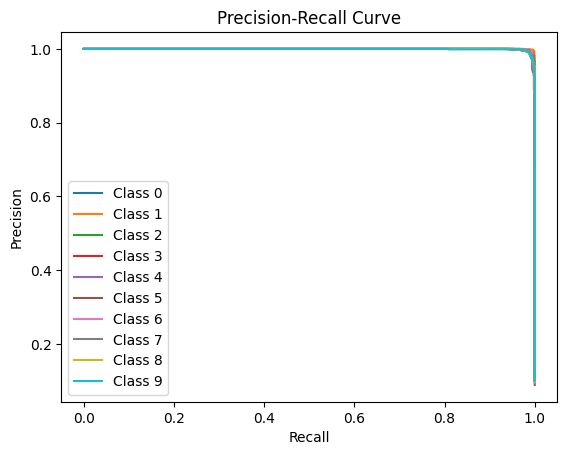

In [62]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Assuming y_test and y_pred_cat (predicted probabilities) are defined
# Binarize the true labels (y_test)
y_test_bin = label_binarize(y_test, classes=range(10))

# y_pred_cat should be the probabilities predicted by the model
# Make sure y_pred_cat is a numpy array of shape (num_samples, num_classes)
# y_pred_cat = model.predict(X_test) # This should be already done

# y_pred_cat contains probabilities, no need to binarize y_pred_cat
for i in range(10):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()